# Product recommendation engine
---
![](resources/groceries.jpg)

## Main objective:
---
Imagine we are a grocery store owner, and we are trying to maximize the purchases of our customers per visit. 

A first strategy that comes to our mind is placing products next to each other that are usually bought together.

Since we have succesfully completed a Data Science task in the past we immediately realize that this problem can be formulated as a recommendation task.


The machine learning part has the following goal:


Essentially we will try to predict the last item of a customers purchase list, given all the other items that he has already in his shopping basket. Those predictions are a helpful first heuristic for the placement of certain products in our grocery store. 

Thus we start collecting the purchase histories of past customers and start writing down the following steps needed, to build our recommendation pipeline:


### Plan of attack:
1. Load the customer purchase data, located in 'data/training_data.csv', 'data/training_labels.csv'
    - Note on the dataset: Each row in each of the data files refers to one 'incomplete' item-list of a customers purchase.
    - The labels represent the item that was purchased by the customer in addition to the items in the dataset
    
    
2. Plot the following statistics on the joined datasets(train_x + train_y):

    - histogram of 10 most purchased products
    - pie chart of all product purchase frequencies(use top ten frequencies)
    - which other interesting plots can you think of ? -> extra points
    

3. Compute and present the following results on joined data sets, train_x + train_y(you are free to choose any method to present your results):

    - Find the pair of products, that are bought together the most
    - Which product was the least purchased ?


4. Transform it into a Machine learning-classifier digestable format:
    - Machine learning algorithms consume data, that has a unified format!
    - For example it should look like that:
    
    
    | feature 1(e.g. product/grocery): | feature 2: | ... | feature N: |
    | "apple"                          | "banana"   | ... | mango      |
    --------------------------------------------------------------------
    | no                               | yes        | ... | no         | <- customer 1: purchased only banana 
    --------------------------------------------------------------------
    | yes                              | yes        | ... | yes        | <- customer 2: purchased all 3 shown
    -------------------------------------------------------------------- 
                                .
                                .
                                .
    --------------------------------------------------------------------
    | no                              | no         | ... | no          | <- customer N: purchased nothing
    --------------------------------------------------------------------
    


5. Train your model on the training set(=train_x, train_y), and predict an item for the each row in the test set(=test_x).DON'T change the order of the test set:

    - Item-predictions should be in the original string format(=item name)
    - You can predict numerical values and then convert them back into strings

6. Save the predictions(=string representations) for the test set in a csv-file


### Note on implementation:
- You are free to use any classification algorithm that you want. If you find better recommendation approaches on the web(there certainly are better, but also more involved ones), you are free to use those.
- Some proven algorithms, other than the ones learned in the lectures are: 
    - https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26
    - https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

### Note on grading:
- End result on the classification task = 25%
- Clean code(e.g. classes instead of script like functions etc.) = 25 %
- Documentation = 25%
- Usage of numpy, pandas, pyplot etc. functions for faster computation = 25%

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.pipeline import Pipeline


# You need to pip install squarify if you dont have it, if you dont you dont see the tree-driagram
# Can comment these out if you need
#import squarify

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.utils.data as data_utils

In [3]:
train_x = pd.read_csv('data/training_data.csv', header=None)
test_x = pd.read_csv('data/test_data.csv', header=None)
train_y = pd.read_csv('data/training_labels.csv', header=None)

In [4]:
#Dataset Class
class DataSet():
    def __init__(self, x, y = None):
        self.x = x
        
        # if no labels are given, then build target vector with equal size to x with zeros.
        if y is None:
            self.y = pd.DataFrame(np.zeros((self.x.shape[0])))
        else:
            self.y = y
        
    # Helper-function: Return cleaned Train+Test Data
    def CleanData(self): 
        self.x = self.x.fillna(0)
        self.y.columns = ["label"]

        # remove rows from x where all entries are 0 and remove rows from y where all rows are 0 in x.
        self.y = self.y[(self.x.T != 0).any()]
        self.x = self.x[(self.x.T != 0).any()]

        # fix naming mistake with asparagus:
        self.x = self.x.replace(' asparagus', 'asparagus')
        self.y = self.y.replace(' asparagus', 'asparagus')
        #return self.x, self.y

    # Helper-function: Return flat array of cleaned,merged Train+Test Data
    def MergeFlat(self): 
        xy = pd.concat([self.x, self.y], axis = 1)
        xy_flat = xy.values.ravel()
        return xy_flat

    # Return unique items present in (Train+Test) Dataset (== num_classes)
    def Unique(self): 
        xy_flat = self.MergeFlat()
        unique_items = pd.unique(xy_flat)
        unique_items = unique_items[unique_items != 0]
        return unique_items
    
    #Return the n (top=10) most frequent classes and their frequencies in the dataset.
    def Freqs(self, top = 10): 
        freqs = self.MergeFlat()
        freqs = freqs[freqs != 0]
        freqs = pd.value_counts(freqs)
        tt_freqs = freqs[:top]
        tt_index = freqs[:top].index
        tt_freqs.rename(rows=tt_index)

        return tt_index, tt_freqs

    #Plot graphs for this dataset
    def PlotInfo(self, top = 10, bar=True, pie = True, tree = False): #Add other graphs if you want
        myitems, myfreqs = self.Freqs()
        numplots = bar + pie + tree #this variable isnt used for now

        #Barplot
        if bar == True:
            plt.figure(figsize=(10,10))
            plt.xticks(rotation=90)
            plt.bar(myitems, myfreqs)

        #pieplot
        if pie == True:
            plt.figure(figsize=(10,10))
            plt.pie(labels = myitems, x = myfreqs)
            plt.show()
            
        #Treeplot    
        #if tree == True:
        #    try:
        #        squarify.plot(sizes=myfreqs, label=myitems, alpha=.8, color=["red","green","blue","yellow","purple","cyan","pink","grey", "orange", "magenta", "brown", "olive"])
        #        plt.figure(figsize=(10,10))
        #        plt.axis('off')
        #        plt.show()
        #    except:
        #        print("Need to install squarify to see tree-diagram")
            

    #This function one-hot encodes the dataset(x), and represents 
    # the label as its numeric index in the alphabetically sorted list of classes.
    def Hot(self,items, label = False): 
                                        
        if not label:
            new = self.x
        else:
            new = self.y
            
        if not label:
            new = new.replace(0, np.nan)
            new = np.ravel(new)
            
            #19 rows belong to same costumer (there are 19 purchase-columns without test)
            new = pd.get_dummies(new, columns = items)
            
            #If sub-dataset is missing classes from total dataset, we add them here.
            for item in items:                        
                if item not in new.columns:
                    new[item] = 0
    
            #Merge 19 rows together for proper 1hot encoding
            new = new.groupby(new.index // 19).sum() 
            
            #sort classes (columns) alphabetically
            #new = new.reindex(sorted(new.columns), axis=1) 
            self.x = new

        elif label:
            
            # replace class with index of class of [classes]
            for item in items:
                new = new.replace(item, pd.Index(items).get_loc(item)) 
            self.y = new

        else:
            return("incorrect dimension")
    
    #Extracts X and y from the Dataset object as a tuple
    def Extract(self):
        return self.x, self.y
    
    #Find the pairs that occur most often together in a purchase. Can filter out items by "exception = [...]"
    def MaxPair(self, classes, exception = None):
        if exception is None:
            exception = []
            
        pair = {}
        temp_classes = classes.copy()
        
        #merge labels & data, add nans (they will be ignored by dummies)
        xy = pd.concat([self.x, self.y], axis = 1)
        xy = xy.replace(0, np.nan)
        
        #group by item to search for
        for item1 in classes:
            group = xy.groupby(item1)
            
            ## prevent duplicate pairs
            temp_classes = np.delete(temp_classes, np.nonzero(temp_classes==item1)) 
            for item2 in temp_classes:
                if (item1 not in exception) and (item2 not in exception):
                    pair[f'{item1} and {item2}'] = group[item2].value_counts().max()
        
        # Key of maximum value in pair
        maxkey = max(pair, key=pair.get)
        if len(exception) == 0:
            print(f'The pair that appears most often is: {maxkey}, it appears {pair[maxkey]} times')
        elif type(exception) == str:
            print(f'Besides {exception}, the pair that appears most often is: {maxkey}, it appears {pair[maxkey]} times')
        else:
            exception = " & ".join(exception)
            print(f'Besides {exception}, the pair that appears most often is: {maxkey}, it appears {pair[maxkey]} times')
        return maxkey, pair[maxkey]
    
#print(pair)
    
# Functions of Model Class  
class Model():
    
    # Initialize model (string for now)
    def __init__(self, model): #Model can be SVM, LR or NN.
        self.modeltype = model
    
    #depending on the chosen model, train model on train_data and train_labels
    def Train(self, X, y):
        y = np.ravel(y)
        if self.modeltype == 'SVM':
            self.model = svm.SVC()
            self.model.fit(X, y)
            return self
        
        elif self.modeltype == 'LR':
            self.model = LogisticRegression()
            self.model.fit(X, y)
            return self
        
        #elif self.modeltype == 'NN':
        #    self.model = NeuralNet(19, 119)
        #    self.optimizer = torch.optim.SGD(params=neural_net.parameters(), lr=0.01)
        #    self.loss_fn = torch.nn.CrossEntropyLoss()
        #    self.Train()
            
        elif self.modeltype == 'NCA':
            self.model = NeighborhoodComponentsAnalysis(random_state=42)
            self.knn = KNeighborsClassifier(n_neighbors=3)
            self.nca_pipe = Pipeline([('nca', self.model), ('knn', self.knn)])
            self.nca_pipe.fit(X_train, y_train)
            return self
            
            
        return("Training complete")
    
    #depending on the chosen model, predict new labels given old data.
    def Predict(self, x):
        if self.modeltype == 'SVM':
            self.prediction = self.model.predict(x)
        
        elif self.modeltype == 'LR':
            self.prediction = self.model.predict(x)
        
        elif self.modeltype == 'NN':
            pass
        
        elif self.modeltype == 'NCA':
            self.prediction = self.nca_pipe.predict(x)
        
        return self.prediction

    def Accuracy(self, y):
        y = np.ravel(y)
        #print(self.prediction.shape, y.shape)
        right, wrong = 0, 0
        
        # compare every column for prediction & label, increase counters for either right or wrong
        for i in range(len(self.prediction)):
            if (int(self.prediction[i]) == int(y[i])):
                right += 1
            else:
                wrong += 1
                
        # calculate accuracy
        accuracy = np.round(right/(right+wrong)*100, 2)
        
        print(f'The accuracy of this Model on the dataset is {accuracy}%')
        return accuracy
        


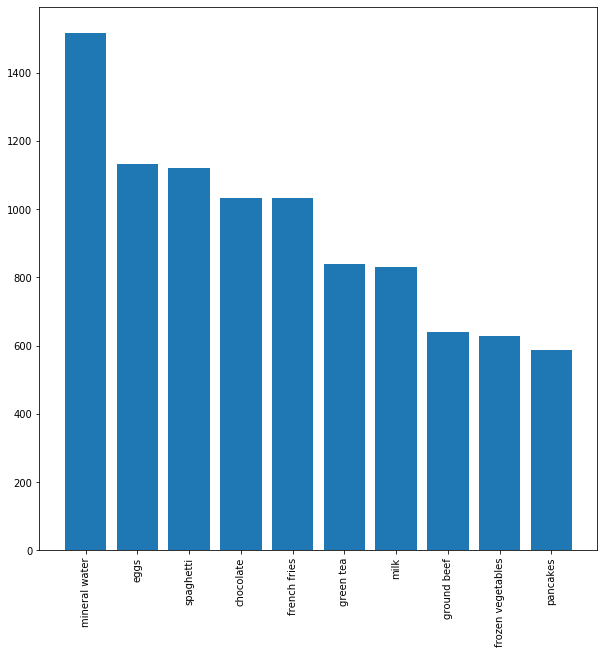

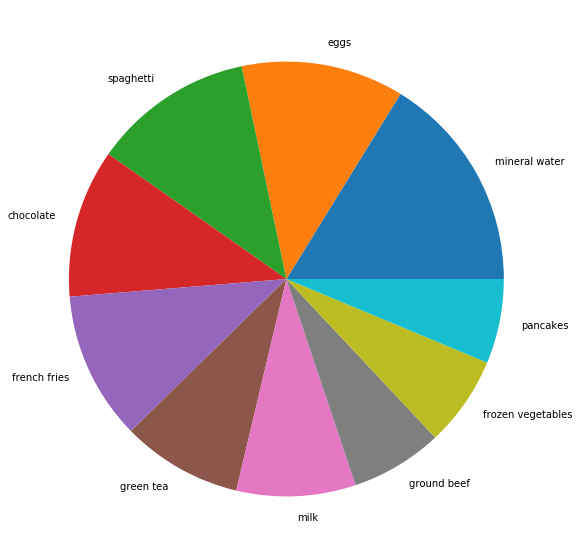

In [5]:
# Cleaning & Hot encoding Data (trainset)
traindata = DataSet(train_x, train_y)
traindata.CleanData()

# Show info and distribution for Dataset
traindata.PlotInfo(tree=True)

# Define classes from total data, onehot encode train data & labels
classes = traindata.Unique()
traindata.Hot(classes, label = False) #this if or the data (x), info is stored inside object
traindata.Hot(classes, label = True) #this is for the labels (y), info is stored inside object

# Extract features (X) and labels (y) from dataset object
X, y = traindata.Extract()

# Splitting and shuffling train data-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

# Little check to see shapes & confirm everything went fine
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [6]:
#Find the pair of items that was bought together most frequently in the dataset:
traindata.MaxPair(classes)

#Find the pair of items that was bought together most frequently in the dataset excluding those in exception:
traindata.MaxPair(classes, exception = 'spaghetti')

traindata.MaxPair(classes, exception = ['spaghetti','mineral water'])
#it's not burgers and almonds by the way

The pair that appears most often is: spaghetti and mineral water, it appears 305 times
Besides spaghetti, the pair that appears most often is: eggs and mineral water, it appears 268 times
Besides spaghetti & mineral water, the pair that appears most often is: eggs and french fries, it appears 195 times


('eggs and french fries', 195)

In [7]:
# Cleaning & Hot encoding Data (testset)
testdata = DataSet(test_x.drop(columns=0))
testdata.CleanData()
testdata.Hot(classes, label = False)
X_testset, _ = testdata.Extract()

In [8]:
# Train and Predict with chosen Model (support vector machines)
SVM = Model('SVM');
SVM.Train(X_train, y_train);
SVM.Predict(X_test);
SVM.Accuracy(y_test);

D:\software\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The accuracy of this Model on the dataset is 14.49%


In [9]:
# Make predictions for testset data (X_testset)
X_testset_prediction = SVM.Predict(X_testset)
item_prediction = pd.DataFrame(classes[X_testset_prediction])

item_prediction.to_csv('data/item_prediction.csv', header=None, index=None)

In [10]:
#############################################################################################################
#
# End of 'serious Project', the rest is me playing around with other models & neural networks
#
#############################################################################################################

In [11]:
# Train and Predict with chosen Model (knn & NeighborhoodComponentsAnalysis)
NCA = Model('NCA');
NCA.Train(X_train, np.ravel(y_train));
NCA.Predict(X_test);
NCA.Accuracy(np.ravel(y_test));

D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\software\anaconda\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


The accuracy of this Model on the dataset is 10.43%


In [12]:
# Train and Predict with chosen Model (Logistic Regression)
LR = Model('LR');
LR.Train(X_train, np.ravel(y_train));
LR.Predict(X_test);
LR.Accuracy(np.ravel(y_test));

D:\software\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\software\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The accuracy of this Model on the dataset is 21.26%


In [13]:
### Try to add Neural Networks



class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        
        sample = {}
        sample["features"] = self.features[idx]
        sample["labels"] = self.labels[idx]
        
        return sample

class NeuralNet(torch.nn.Module):
    
    def __init__(self, input_dim, num_classes):
        super(NeuralNet, self).__init__()
        
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        self.linear_layer1 = torch.nn.Linear(self.input_dim, 120)
        #self.linear_layer2 = torch.nn.Linear(40, 25)
        self.linear_layer3 = torch.nn.Linear(120, self.num_classes)
        
        nn.init.xavier_uniform_(self.linear_layer1.weight)
        #nn.init.xavier_uniform_(self.linear_layer2.weight)
        nn.init.xavier_uniform_(self.linear_layer3.weight)
        
        #self.drop = nn.Dropout(p=.5)
        
    def forward(self, x):
        
        # Layer 1 + activation
        x = self.linear_layer1(x.view(-1, self.input_dim))
        x = F.relu(x)
        #x = self.drop(x)                     
        # Layer 2
        #x = self.linear_layer2(x)
        
        # Layer 3
        x = self.linear_layer3(x)
        
        return x 
    
    def Eval(self, test_loader, test = True):
        correct = 0
        total = 0
        self.eval()
        with torch.no_grad():
            for sample in test_loader:
                data = sample['features']
                labels = sample['labels']
                
                data = data.type(torch.FloatTensor)
                outputs = neural_net.forward(data)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        if test:
            print('Validation accuracy %d %%\n' % (100 * correct / total))
        else:
            print('Training accuracy %d %%' % (100 * correct / total))
    
    def Train(self, train_loader, test_loader, num_epochs=5):
        
        print("Beginning training")
        
        for epoch in range(num_epochs):
            running_loss = 0.0
            
            self.train()
            for i, sample in enumerate(train_loader, 1):
                
                data = sample['features']
                labels = sample['labels']
                
                #labels = labels.type(torch.FloatTensor)
                data = data.type(torch.FloatTensor)

                # forward pass
                #print(data)
                #print(labels)
                predictions = neural_net.forward(data)
                #print(predictions)

                # backward pass + optimization step
                loss = loss_fn(predictions, labels)

                # backward pass + optimization step
                loss = loss_fn(predictions, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()

                #if i % 1000 == 0:
                #    print(f'Epoch: {epoch+1}, loss: {running_loss / i}')
                
            
            print(f'\nLoss after epoch: {epoch+1} = {running_loss / len(train_loader)}')
            self.Eval(train_loader, test = False)
            self.Eval(test_loader)
        



In [14]:
XTtrain, XTtest, yTtrain, yTtest = train_test_split(torch.tensor(X.values), torch.tensor(y.values), test_size = 0.2, shuffle=True)
torchtrain = MyDataset(XTtrain, yTtrain)
torchtest = MyDataset(XTtest, yTtest)

neural_net = NeuralNet(119,119)
optimizer = torch.optim.SGD(params=neural_net.parameters(), lr=0.000001, momentum=0.9, weight_decay=1e-5, nesterov=True)
loss_fn = torch.nn.CrossEntropyLoss()
neural_net.Train(torchtrain, torchtest, num_epochs = 50)

# Loss --> -ln(1/119) = 4.7 (So loss 4.7 means random chance to guess correctly).
# SVM performance (18% corresponds to loss of 3.06)
# Best NN performance was 1.37 (40 epochs, 2 layers (H=200), lr=0.000001, but validation max was never above 20%)

TypeError: take(): argument 'index' (position 1) must be Tensor, not numpy.ndarray